In [1]:
# Import various libraries for analysis
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.decomposition import PCA,KernelPCA
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.svm import SVC
color = sns.color_palette()
data_red = pd.read_csv('../input/winequality-red.csv',delimiter=';')
data_white = pd.read_csv('../input/winequality-white.csv',delimiter=';')

In [2]:
# Display data
data_white.head(5)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


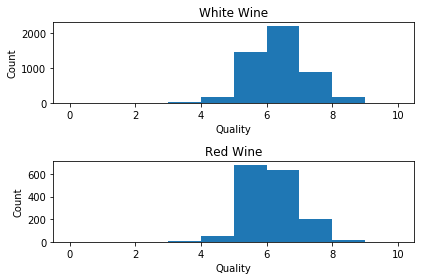

In [3]:
# Plot the distribution of quality
plt.subplot(2,1,1)
plt.hist(data_white['quality'],bins=[0,1,2,3,4,5,6,7,8,9,10]);
plt.xlabel('Quality')
plt.ylabel('Count')
plt.title('White Wine')

plt.subplot(2,1,2)
plt.hist(data_red['quality'],bins=[0,1,2,3,4,5,6,7,8,9,10]);
plt.xlabel('Quality')
plt.ylabel('Count')
plt.title('Red Wine')

plt.tight_layout()
plt.show()

In [4]:
# As seen above, the midpoint fo the quality lies between 6 and 7
# Make a bianry classification of the Quality to maximize the model effectiveness

score = []
for i in data_white['quality']:
    if i >= 0 and i <= 6:
        score.append('1')
    elif i >= 6 and i <= 10:
        score.append('2')
data_white['score'] = score

data_white.groupby('score').size()

score = []
for i in data_red['quality']:
    if i >= 0 and i <= 6:
        score.append('1')
    elif i >= 6 and i <= 10:
        score.append('2')
data_red['score'] = score

In [5]:
# Red data
x_r = data_red.iloc[:, 0:-2].values
y_r = data_red.iloc[:, 12].values

# White data
x_w = data_white.iloc[:, 0:-2].values
y_w = data_white.iloc[:, 12].values

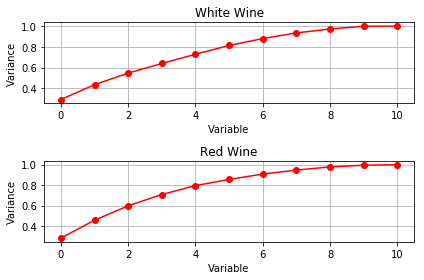

In [6]:
# Rescale the data norm(0,1)
sc_x=StandardScaler() 
x_r = sc_x.fit_transform(x_r)
x_w = sc_x.fit_transform(x_w)

# PCA decomposition to determine the important features
pca=PCA()
x_w_pca = pca.fit_transform(x_w)

# Display the cumulative percentage of variance explained by the PCA components
plt.subplot(2,1,1)
plt.plot(np.cumsum(pca.explained_variance_ratio_), 'ro-')
plt.grid()
plt.xlabel('Variable')
plt.ylabel('Variance')
plt.title('White Wine')

# PCA on the red wine
x_r_pca = pca.fit_transform(x_r)

# Display the red
plt.subplot(2,1,2)
plt.plot(np.cumsum(pca.explained_variance_ratio_), 'ro-')
plt.grid()
plt.xlabel('Variable')
plt.ylabel('Variance')
plt.title('Red Wine')

plt.tight_layout()
plt.show()

In [7]:
# The last component contributes negligably to the variance
pca_w_new = PCA(n_components=9)
x_w_new = pca_w_new.fit_transform(x_w)
pca_r_new = PCA(n_components=9)
x_r_new = pca_r_new.fit_transform(x_r)

In [8]:
# Split the data into training and test sets based on the PCA transformation
X_w_train, X_w_test, y_w_train, y_w_test = train_test_split(x_w_new, y_w, test_size = 0.2, random_state = 1)
X_r_train, X_r_test, y_r_train, y_r_test = train_test_split(x_r_new, y_r, test_size = 0.2, random_state = 1)

In [9]:
# Define classifiers for different models for the red and white wines
def classifier_w(model):
    
    # Fit the model
    model.fit(X_w_train,y_w_train)
    
    # Predict on the cross-validation test set
    y_pred=model.predict(X_w_test)
    
    # Score the model
    score=accuracy_score(y_pred,y_w_test)
    return score*100

def classifier_r(model):
    
    # Fit the model
    model.fit(X_r_train,y_r_train)
    
    # Predict on the cross-validation test set
    y_pred=model.predict(X_r_test)
    
    # Score the model
    score=accuracy_score(y_pred,y_r_test)
    return score*100

In [10]:
# Test various models for accuracy
print('Red SVC Score: ', classifier_r(SVC(gamma = 'auto')))
print('Red KNN Score: ', classifier_r(KNeighborsClassifier(n_neighbors=100)))
print('Red RF Score: ', classifier_r(RandomForestClassifier(n_estimators=100)))
print('Red GNB Score: ', classifier_r(GaussianNB()))

print('White SVC Score: ', classifier_w(SVC(gamma = 'auto')))
print('White KNN Score: ', classifier_w(KNeighborsClassifier(n_neighbors=100)))
print('White RF Score: ', classifier_w(RandomForestClassifier(n_estimators=100)))
print('White GNB Score: ', classifier_w(GaussianNB()))

Red SVC Score:  90.0
Red KNN Score:  91.5625
Red RF Score:  92.5
Red GNB Score:  87.1875
White SVC Score:  81.42857142857143
White KNN Score:  80.20408163265306
White RF Score:  88.36734693877551
White GNB Score:  78.6734693877551


In [11]:
# The Random Forest (RF) Classifier is the best in all cases

# Make the RF Classifiers
forest_r = RandomForestClassifier(n_estimators=250)
forest_w = RandomForestClassifier(n_estimators=250)
rf_r = forest_r.fit(X_r_train,y_r_train)
rf_w = forest_w.fit(X_w_train,y_w_train)

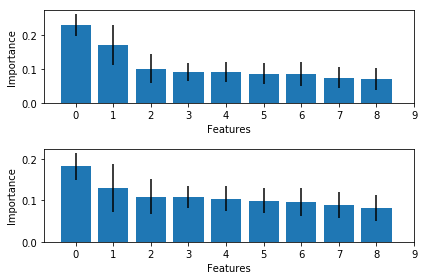

In [12]:
# Standard error for the trees in the classifiers
std_r = np.std([tree.feature_importances_ for tree in forest_r.estimators_],
             axis=0)
std_w = np.std([tree.feature_importances_ for tree in forest_w.estimators_],
             axis=0)

# Get the importance of each feature
importance_r = rf_r.feature_importances_
importance_w = rf_w.feature_importances_

# Sort the features by importance
indices_r = np.argsort(importance_r)[::-1]
indices_w = np.argsort(importance_w)[::-1]

# Show the PCA Feature importance
plt.subplot(2,1,1)
plt.bar(range(X_r_train.shape[1]),importance_r[indices_r],yerr = std_r)
plt.xticks(np.arange(10))
plt.xlabel('Features')
plt.ylabel('Importance')

plt.subplot(2,1,2)
plt.bar(range(X_w_train.shape[1]),importance_w[indices_w],yerr = std_r)
plt.xticks(np.arange(10))
plt.xlabel('Features')
plt.ylabel('Importance')
plt.tight_layout()

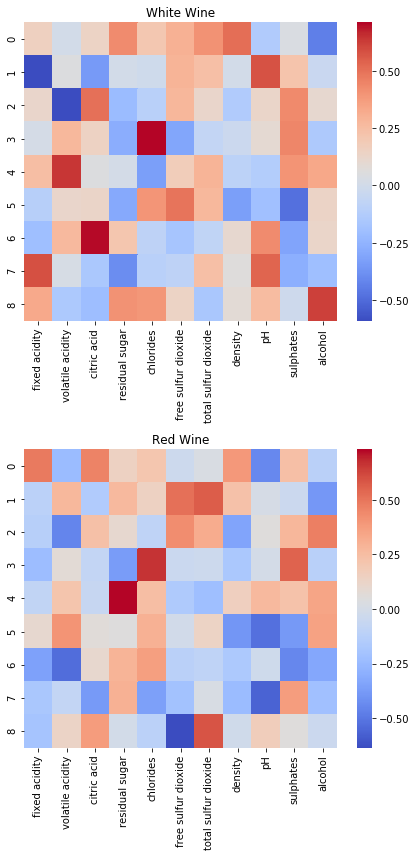

In [13]:
# Decode what the features are from the PCA
params_w = pd.DataFrame(pca_w_new.components_,columns = data_red.iloc[:,0:11].columns)
params_r = pd.DataFrame(pca_r_new.components_,columns = data_red.iloc[:,0:11].columns)

# Take the absolute value since the component sign is irrelevant
params_w = params_w
params_r = params_r

# Plot heatmaps of the parameters in descending order of importance
f, axes = plt.subplots(2, 1,figsize=(6,12))
sns.heatmap(data = params_w, ax=axes[0], cmap = "coolwarm").set_title('White Wine')
sns.heatmap(data= params_r, ax=axes[1], cmap = "coolwarm").set_title('Red Wine')
plt.tight_layout()